# CRISM summary products Python API 

Developed on Python 3 - Anik Halder, Ramiro Marco Figuera

In [1]:
import numpy as np

import re

from astropy.io import fits

%matplotlib inline
import urllib.request
import urllib.parse
import matplotlib.pyplot as plt

# reading the data from the bands_table.fits file

hdulist = fits.open("bands_table.fits")
tabledata = hdulist[1].data # assuming the first extension is a table

cols = hdulist[1].columns

band_name = tabledata["band_name"]
WV = tabledata["wavelength"]

In [2]:
def find_WV_bandname(name, nearest=True):
    # extract wavelength from formulation name e.g. R2950 --> 2950 nanometer --> 2.95 micrometer
    # nearest=True means that the nearest wavelength in the bands_table will be returned (default value)
    # nearest=False means that the exact wavelength as passed in 'name' shall be returned
    
    l = float(re.findall("\d+", name)[0])/1000 # converting into micrometer
    
    # nearest wavelength and the corresponding band name index of the given color
    idx = (np.abs(WV-l)).argmin()
    
    # return the corresponding values
    if (nearest==True):
        return WV[idx], band_name[idx]
    elif (nearest==False):
        return l, band_name[idx]


color = "R2260"

results = find_WV_bandname(color)

print("Corresponding wavelength and bandname of", color ,": WV =", results[0],
      "; Band name", results[1])

Corresponding wavelength and bandname of R2260 : WV = 2.25827 ; Band name 192


### Formulation of family $f1$ $$1-\frac{R_c}{a\cdot R_s+b\cdot R_l}$$

Associated Product # : 13, 19, 20, 21, 23, 27, 28, 29, 31, 33, 34, 36, 37, 39, 44, 46, 47, 48, 57
##### 19 summary products

In [17]:
# family f1 is of the formuation : 1-(Rc/(a*Rs+b*Rl)

def f1(lst = []):
    # lst has the arguments: Rc, Rs, Rl
    WV_Rc , bn_Rc = find_WV_bandname(lst[0]) # Rc
    WV_Rs , bn_Rs  = find_WV_bandname(lst[1]) # Rs
    WV_Rl , bn_Rl  = find_WV_bandname(lst[2]) # Rl

    #print("Band names : {0} = {1}, {2} = {3}, {4} = {5}".format(lst[0], bn_Rc, lst[1], bn_Rs, lst[2], bn_Rl))    
        
    b = (WV_Rc - WV_Rs) / (WV_Rl - WV_Rs)
    a = 1-b
    
    # WCPS query as given by the computed product
    F = "1 - (data.band_"+str(bn_Rc)+" / (("+str(a)+") * data.band_"+str(bn_Rs)+" + ("+str(b)+") * data.band_"+str(bn_Rl)+"))"
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
    
    print (FS)
        
    return FS, [F]

### Formulation of family  $f2$ (Yet to be done) $$minimum [1-\frac{R_{1c}}{a\cdot R_{1s}+b\cdot R_{1l}}, 1-\frac{R_{2c}}{a\cdot R_{2s}+b\cdot R_{2l}}]$$

In [18]:
# family f2 is of the formuation : MIN [ 1-(R1c/(a*R1s+b*R1l) , 1-(R2c/(a*R2s+b*R2l) ]

def f2(lst = []):
    # lst has the arguments: Rc1, Rs1, Rl1 , Rc2, Rs2, Rl2
    
    F1, FS1 = f1(lst[0:3])
    F2, FS2 = f1(lst[3:])
    
    ####################################################################
    # Comparison not possible as associated band values haven't yet been computed in f1 formulation
    ####################################################################
    
    if (val1>=val2):
        a = a1
        b = b1
        val = val1
        FS = FS1
        print("\nMinimum value is given by the first set of bands")
    else:
        a = a2
        b = b2
        val = val2
        FS = FS2
        print("\nMinimum value is given by the second set of bands")
    
    return a , b, val, FS

### Formulation of family $f3$ $$0.5 \cdot (1-\frac{R_{1c}}{a\cdot R_{1s}+b\cdot R_{1l}}) + 0.5 \cdot (1-\frac{R_{2c}}{a\cdot R_{2s}+b\cdot R_{2l}})$$

Associated Product # : 24

##### 1 summary product

In [19]:
# family f3 is of the formuation : 0.5 * (1-(R1c/(a*R1s+b*R1l)) + 0.5*( 1-(R2c/(a*R2s+b*R2l))

def f3(lst = []):
    # lst has the arguments: R1c, R1s, R1l, R2c, R2s, R2l
    
    FS1, F1 = f1(lst[0:3]) # for components R1c, R1s, R1l
    FS2, F2 = f1(lst[3:]) # for components R2c, R2s, R2l
    
    # WCPS query as given by the computed product
    F = "0.5 * ("+F1[0]+")"+" + 0.5 * ("+F2[0]+")" 
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
        
    return FS, [F]

### Formulation of family $f4$ $$R_1$$

Associated Product # : 12, 54, 55, 56, 60

##### 5 summary products

In [20]:
# family f4 is of the formuation : R1

def f4(lst = []):
    # lst has the arguments: R1
    
    WV_R1 , bn_R1 = find_WV_bandname(lst[0]) # R1
    
    # WCPS query as given by the computed product
    F = "data.band_"+str(bn_R1)
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
        
    return FS, [F]

### Formulation of family $f5$ $$\frac{R_1}{R_2}$$

Associated Product # : 58, 59

##### 2 summary products

In [21]:
# family f5 is of the formuation : R1/R2

def f5(lst = []):
    # lst has the arguments: R1, R2
    
    WV_R1 , bn_R1 = find_WV_bandname(lst[0]) # R1
    WV_R2 , bn_R2 = find_WV_bandname(lst[1]) # R2
    
    # WCPS query as given by the computed product
    F = "data.band_"+str(bn_R1)+" / data.band_"+str(bn_R2)
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
        
    return FS, [F]

### Formulation of family $f6$ $$1-(\frac{R_1}{R_2 \cdot \frac{R_3}{R_4}})$$

Associated Product # : 45

##### 1 summary product

In [22]:
# family f6 is of the formuation : 1-(R1/(R2*(R3/R4)))

def f6(lst = []):
    # lst has the arguments: R1, R2, R3, R4
    
    WV_R1 , bn_R1 = find_WV_bandname(lst[0]) # R1
    WV_R2 , bn_R2  = find_WV_bandname(lst[1]) # R2
    WV_R3 , bn_R3  = find_WV_bandname(lst[2]) # R3
    WV_R4 , bn_R4  = find_WV_bandname(lst[3]) # R4

    # WCPS query as given by the computed product
    F = "1 - (data.band_"+str(bn_R1)+" / (data.band_"+str(bn_R2)+" * (data.band_"+str(bn_R3)+" / data.band_"+str(bn_R4)+")))"
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
        
    return FS, [F]

### Formulation of family $f7$ $$1-\frac{a\cdot R_s+b\cdot R_l}{R_c}$$

Associated Product # : 40, 49

##### 2 summary products

In [23]:
# family f7 is of the formuation : 1-((a*Rs+b*Rl)/Rc)

def f7(lst = []):
    # lst has the arguments: Rs, Rl, Rc

    WV_Rs , bn_Rs  = find_WV_bandname(lst[0]) # Rs
    WV_Rl , bn_Rl  = find_WV_bandname(lst[1]) # Rl
    WV_Rc , bn_Rc = find_WV_bandname(lst[2]) # Rc

    #print("Band names : {0} = {1}, {2} = {3}, {4} = {5}".format(lst[2], bn_Rc, lst[0], bn_Rs, lst[1], bn_Rl))    
        
    b = (WV_Rc - WV_Rs) / (WV_Rl - WV_Rs)
    a = 1-b
    
    # WCPS query as given by the computed product
    F = "1 - ( (("+str(a)+") * data.band_"+str(bn_Rs)+" + ("+str(b)+") * data.band_"+str(bn_Rl)+") / data.band_"+str(bn_Rc)+")"
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
        
    return FS, [F]

### Formulation of family $f8$ $$1-(\frac{1-BD_1}{1-BD_2})$$

Associated Product # : 22

##### 1 summary product

In [24]:
# family f8 is of the formuation : 1-((1-BD1)/(1-BD2)) i.e. composed of f1

def f8(lst = []):
    # lst has the arguments: dictionary, BD1, BD2
    
    dictionary = lst[0] 
    FS1, F1 = dictionary[lst[1]][0](dictionary[lst[1]][1])
    FS2, F2 = dictionary[lst[2]][0](dictionary[lst[2]][1])
    
    # WCPS query as given by the computed product
    F = "1 - ((1 - "+F1[0]+") / (1 - "+F2[0]+"))"
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
    
    return FS, [F]

### Formulation of family $f9$ $$(\frac{R_1-R_2}{W_2-W_1})$$

Associated Product # : 18

##### 1 summary product

In [25]:
# family f9 is of the formuation : ((R1-R2)/(W1-W2))

def f9(lst = []):
    # lst has the arguments: R1, R2
    
    WV_W1, bn_R1 = find_WV_bandname(lst[0], nearest=False) # W1 and R1
    WV_W2, bn_R2 = find_WV_bandname(lst[1], nearest=False) # W2 and R2
    
    slope = "((data.band_"+str(bn_R1)+" - data.band_"+str(bn_R2)+") / ("+str(WV_W2)+" - "+str(WV_W1)+"))"
    
    intercept = "(data.band_"+str(bn_R2)+" - "+slope+" * "+str(WV_W2)+")"    
    
    # WCPS query as given by the computed product
    F = slope
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
    
    return FS, [slope, intercept]    

In [26]:
def RC(lst = []):
    # lst has the arguments: RC, [R1, R2] with R1 and R2 the anchors
    
    WV_RC = find_WV_bandname(lst[0], nearest=False)[0]
    
    slope, intercept = f9(lst[1])[1]
    
    F = "("+slope+" * "+str(WV_RC)+" + "+intercept+")"

    return F

#RC(["RB2600",["R2456", "R2530"]])

### Formulation of family $f10$ $$RBXXXX =\frac{RCXXXX - RXXXX }{RCXXXX}$$

Associated Product # : 41

##### 1 summary product

In [27]:
# family f10 is of the formuation : RB1 = (RC1 - R1) / R1

def f10(lst = []):
    # lst has the arguments: RB, [R1, R2] where R1, R2 are the anchors
    
    # note that for finding bandname of a product, the initials do not matter i.e. whethe it is RBXXXX,
    # RCXXXX or RXXXX - all have the same bandnames
        
    F_RC = RC(lst)
    F_R = f4(lst)[1] # Using formulation of family f4 : R1
    
    F = "(("+F_RC+" - "+F_R[0]+")/ "+F_RC+")"
    
    # stretched value of F
    FS = "(float)((int)( 255 / ( max("+F+") - min("+F+") )) * ( ("+F+") - min("+F+") ))" 
    
    return FS, [F]    

### Formulation of family $f11$ (Yet to be done) $$OLINDEX3$$

Associated Product # : 14

##### 1 summary product

In [32]:
def URL_creator(coverage_id, red, green, blue, products):
    # Takes the coverage_id, the bands in red, green and blue and computes their corresponding
    # products by looking up from the passed dictionary "products"
    
    # storing FS for each channel with corresponding family function in FS1, FS2, FS3 resp.
    FS1, F1 = products[red][0](products[red][1])
    FS2, F2 = products[green][0](products[green][1])
    FS3, F3 = products[blue][0](products[blue][1])
    
    #print("Red: "+F1[0])
    #print("\nGreen: "+F2[0])
    #print("\nBlue: "+F3[0])
    
    URL = "http://access.planetserver.eu:8090/python?wcpsQuery=http://access.planetserver.eu:8080/rasdaman/ows?service=WCS&version=2.0.1&request=ProcessCoverages&query=for data in ( "+coverage_id+" ) return encode({ red: "+FS1+";green: "+FS2+";blue: "+FS3+";alpha: (float)((data.band_100 > 0) * 255)}, \"tiff\", \"nodata=65535\")"
        
    # encoding the URL (not all of it, only from "for in data")
    index = URL.find("for")
    string_to_encode = URL[index:]
    s = urllib.parse.quote(string_to_encode)
    
    encoded_URL = URL[:index]+s
    
    f = urllib.request.urlopen(encoded_URL)
    plt.figure(figsize=(9,9))
    # read the image file in a numpy array
    image = plt.imread(f)
    plt.imshow(image)
        
    # return URL, encoded_URL

In [33]:
summary_products = { "BD1300" : [f1, ["R1320", "R1080", "R1750"]], "BD1400" : [f1, ["R1395", "R1330", "R1467"]], 
                    "BD1435" : [f1, ["R1435", "R1370", "R1470"]], "BD1500_2" : [f1, ["R1525", "R1367", "R1808"]], 
                    "BD1750_2" : [f1, ["R1750", "R1690", "R1815"]], "BD2100_2" : [f1, ["R2132", "R1930", "R2250"]], 
                    "BD2165" : [f1, ["R2165", "R2120", "R2230"]], "BD2190" : [f1, ["R2185", "R2120", "R2250"]],
                    "BD2210_2" : [f1, ["R2210", "R2165", "R2250"]], "BD2230" : [f1, ["R2235", "R2210", "R2252"]],
                    "BD2250" : [f1, ["R2245", "R2120", "R2340"]], "BD2265" : [f1, ["R2265", "R2210", "R2340"]],
                    "BD2290" : [f1, ["R2290", "R2250", "R2350"]], "BD2355" : [f1, ["R2355", "R2300", "R2450"]],
                    "BD2500_2" : [f1, ["R2480", "R2364", "R2570"]], "BD3100" : [f1, ["R3120", "R3000", "R3250"]],
                    "BD3200" : [f1, ["R3320", "R3250", "R3390"]], "BD3400_2" : [f1, ["R3420", "R3250", "R3630"]],
                    "BD2600" : [f1, ["R2600", "R2530", "R2630"]], 
                    "MIN2200" : [f2, ["R2165", "R2120", "R2350", "R2210", "R2120", "R2350"]], 
                    "MIN2250" : [f2, ["R2210", "R2165", "R2350", "R2265", "R2165", "R2350"]], 
                    "MIN2295_2480" : [f2, ["R2295", "R2165", "R2364", "R2480", "R2364", "R2570"]], 
                    "MIN2345_2537" : [f2, ["R2345", "R2250", "R2430", "R2537", "R2430", "R2602"]], 
                    "BD1900_2" : [f3, ["R1930", "R1850", "R2067", "R1985", "R1850", "R2067"]], 
                    "R1330" : [f4,["R1330"]], "R1080" : [f4,["R1080"]],  "R1506" : [f4,["R1506"]],
                    "R2529" : [f4,["R2529"]], "R3920" : [f4,["R3920"]],
                    "IRR2" : [f5,["R2530", "R2210"]], "IRR3" : [f5,["R3500", "R3390"]],
                    "BD3000" : [f6,["R3000", "R2530", "R2530", "R2210"]], 
                    "SINDEX2" : [f7, ["R2120", "R2400", "R2290"]], "CINDEX2" : [f7, ["R3450", "R3875", "R3610"]], 
                   "ISLOPE1" : [f9,["R1815", "R2530"]], 
                   "ICER2_2" : [f10,["RB2600",["R2456", "R2530"]]],} 
                    
summary_products["ICER1_2"] = [f8, [summary_products, "BD1435", "BD1500_2"]]

(float)((int)( 255 / ( max(1 - (data.band_50 / ((0.637846388014) * data.band_13 + (0.362153611986) * data.band_115))) - min(1 - (data.band_50 / ((0.637846388014) * data.band_13 + (0.362153611986) * data.band_115))) )) * ( (1 - (data.band_50 / ((0.637846388014) * data.band_13 + (0.362153611986) * data.band_115))) - min(1 - (data.band_50 / ((0.637846388014) * data.band_13 + (0.362153611986) * data.band_115))) ))
(float)((int)( 255 / ( max(1 - (data.band_50 / ((0.637846388014) * data.band_13 + (0.362153611986) * data.band_115))) - min(1 - (data.band_50 / ((0.637846388014) * data.band_13 + (0.362153611986) * data.band_115))) )) * ( (1 - (data.band_50 / ((0.637846388014) * data.band_13 + (0.362153611986) * data.band_115))) - min(1 - (data.band_50 / ((0.637846388014) * data.band_13 + (0.362153611986) * data.band_115))) ))
(float)((int)( 255 / ( max(1 - (data.band_50 / ((0.637846388014) * data.band_13 + (0.362153611986) * data.band_115))) - min(1 - (data.band_50 / ((0.637846388014) * data.ban

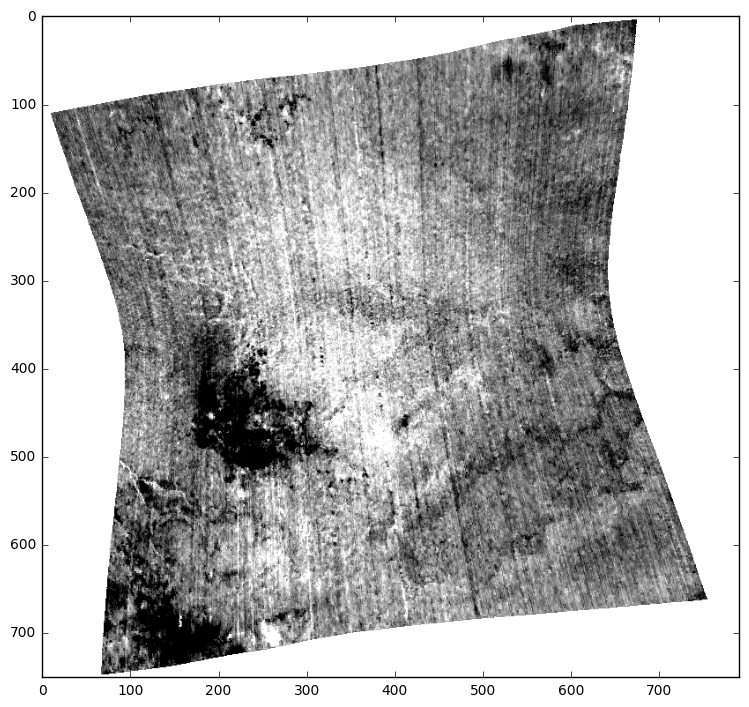

In [35]:
r = "BD1300"
g = "BD1300"
b = "BD1300"

URL_creator("frt000064d9_07_if166l_trr3", r, g, b, summary_products)